# Requirement:
- numpy 1.19.5
- tensorflow 2.5.0
- tensorflow_privacy 0.6.1
- sklearn 0.24.2
- xgboost 1.4.2

Before performing the experiments, you need to fit the **mia_path** (path for MIA package) and **pickle_file**(path for tabular QMNIST data) according to your own PC.

In [5]:
import sys
import os
import pickle
import random
import time

import numpy as np
np.random.seed(12)
import tensorflow as tf
tf.random.set_seed(3)
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tqdm import tqdm

from mia.estimators import prepare_attack_data

# Load QMNIST data and define functions

In [6]:
pickle_file = '/content/QMNIST_tabular.pickle'

with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    x_defender = pickle_data['x_private']
    x_reserve = pickle_data['x_reserved']
    y_defender = pickle_data['y_private']
    y_reserve = pickle_data['y_reserved']
    del pickle_data
print('Data loaded.')

Data loaded.


In [7]:
NUM_CLASSES = 10

y_defender = y_defender[:,0]
y_reserve = y_reserve[:,0]

y_defender = np.expand_dims(y_defender,axis=1)
y_reserve = np.expand_dims(y_reserve,axis=1)

y_defender = tf.keras.utils.to_categorical(y_defender, num_classes=NUM_CLASSES)
y_reserve = tf.keras.utils.to_categorical(y_reserve, num_classes=NUM_CLASSES)

In [8]:
#l2_norm_clip = 1.0
#noise_multiplier = 1.1

def defender_model_fn(n_hidden_units=128, lr=1e-4):
    """The architecture of the defender (victim) model.
    The attack is white-box, hence the attacker is assumed to know this architecture too."""

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_hidden_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    
    ##if train_with_DP:
    ##from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
    ##train_op = DPKerasSGDOptimizer(
    ##    l2_norm_clip=l2_norm_clip,
    ##    noise_multiplier=noise_multiplier,
    ##    num_microbatches=1, # Possible problem after reducing the size of cost vector in tensorflow-privacy. Check: https://github.com/tensorflow/privacy/issues/17
    ##    learning_rate=1e-4
    ##    )
    ##else:
    
    train_op = tf.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer=train_op,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_ed_ce(attack_test_data):
    ed = np.array([])
    ce = np.array([])

    for i in range(attack_test_data.shape[0]):
        ed = np.hstack((ed,euclidean_distances(attack_test_data[i,NUM_CLASSES:].reshape((1,NUM_CLASSES)), attack_test_data[i,:NUM_CLASSES].reshape((1,NUM_CLASSES))).squeeze()))
        ce = np.hstack((ce,log_loss(attack_test_data[i,NUM_CLASSES:].reshape((1,NUM_CLASSES)), attack_test_data[i,:NUM_CLASSES].reshape((1,NUM_CLASSES)))))

    ed = ed.reshape((len(ed),1))
    ce = ce.reshape((len(ce),1))
    return ed,ce

def get_auc_by_class(y_true, y_pred_proba):
    auc_by_class = []

    # compute auc per class then take the average value
    for i in range(NUM_CLASSES):
        class_indices = np.argmax(y_true, axis=1) == i
        fpr, tpr, thresholds = metrics.roc_curve(class_indices, y_pred_proba[:,i])
        auc = metrics.auc(fpr, tpr)
        auc_by_class.append(auc)

    return np.mean(auc_by_class)

# Black-box optimization

In [56]:
def compute_attack_model(x_train, y_train, x_eval, y_eval, trials=1000):
  # repeat the evaluating process for 'trials' times.
  
  xgb_attack_guesses = np.array([])
  xgb_attack_proba = np.reshape(np.array([[],[]]),(0,2))
  xgb_attack_real = np.array([])

  for i in range(trials):
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=50, eval_metric='logloss',  tree_method='gpu_hist')
    xgb_model.fit(x_train, y_train)

    xgb_proba = xgb_model.predict_proba(x_eval)
    xgb_guesses = xgb_model.predict(x_eval)
    

    xgb_attack_guesses = np.hstack((xgb_attack_guesses,xgb_guesses))
    xgb_attack_proba = np.vstack((xgb_attack_proba,xgb_proba))
    xgb_attack_real = np.hstack((xgb_attack_real,y_eval))

  return xgb_attack_guesses, xgb_attack_proba, xgb_attack_real


def get_attack_data(defender_model, data_in, data_out):
    attack_data, attack_data_dense2, real_membership_labels = prepare_attack_data(
        defender_model, data_in, data_out
    )
    ed, ce = get_ed_ce(attack_data)
    new_attack_data = np.hstack((attack_data,ce,ed))
    complete_attack_data = np.hstack((attack_data_dense2[:,:-10], new_attack_data))
    return complete_attack_data, real_membership_labels

In [73]:
import nevergrad as ng
from sklearn.model_selection import train_test_split

# Prepare examples that were in the training, and out of the training.
data_in = x_defender[:number_records], y_defender[:number_records]

utility = []
privacy = []
params = []

x_Dt, x_Dn, y_Dt, y_Dn = train_test_split(data_in[0], data_in[1], test_size=0.5, shuffle=True, random_state=42)

x_Dts, x_Dte, y_Dts, y_Dte = train_test_split(x_Dt, y_Dt, test_size=0.5, shuffle=True, random_state=43)
x_Dns, x_Dne, y_Dns, y_Dne = train_test_split(x_Dn, y_Dn, test_size=0.5, shuffle=True, random_state=44)

n_train_attacker = x_Dts.shape[0]

def min_privacy_loss(n_hidden_units:int, n_epochs:int, lr:float) -> float:
    # Train XGBoost model on the defender data
    defender_model = defender_model_fn(n_hidden_units, lr)    
    defender_model.fit(x_Dts, y_Dts, epochs=n_epochs, batch_size = 32, validation_data=(x_Dte, y_Dte),shuffle=False, verbose=False)
    # Compute utility of the defender model
    predict_reserve_proba = defender_model.predict_proba(x_Dte)
    predict_reserve = np.argmax(predict_reserve_proba, axis=1)
    label_reserve = np.argmax(y_Dte, axis=1)
    acc = accuracy_score(label_reserve, predict_reserve)
    #defender_auc = get_auc_by_class(y_reserve, predict_reserve_proba)

    #Defender utility constraint
    if acc < 0.9:
        return float("inf")
    else:
        # Prepare data for mock attacker.        
        complete_attack_data, real_membership_labels = get_attack_data(defender_model, (np.vstack((x_Dts,x_Dte)), np.vstack((y_Dts,y_Dte))), (np.vstack((x_Dns,x_Dne)),np.vstack((y_Dns,y_Dne))))

        train_indices = list(range(x_Dts.shape[0]))+list(range(x_Dts.shape[0]+x_Dte.shape[0],x_Dts.shape[0]+x_Dte.shape[0]+x_Dns.shape[0]))
        test_indices = list(range(x_Dts.shape[0],x_Dts.shape[0]+x_Dte.shape[0]))+list(range(x_Dts.shape[0]+x_Dte.shape[0]+x_Dns.shape[0],x_Dts.shape[0]+x_Dte.shape[0]+x_Dns.shape[0]+x_Dne.shape[0]))

        complete_attack_train_data = complete_attack_data[train_indices]
        complete_attack_test_data = complete_attack_data[test_indices]
        real_membership_train_labels = real_membership_labels[train_indices]
        real_membership_test_labels = real_membership_labels[test_indices]
        #complete_attack_test_data, real_membership_test_labels = get_attack_data(defender_model, (x_Dts, y_Dts), (x_Dne,y_Dne))

        # Train mock attacker and compute privacy (loss of the attacker)
        xgb_attack_guesses, xgb_attack_proba, xgb_attack_real = compute_attack_model(complete_attack_train_data, real_membership_train_labels, complete_attack_test_data, real_membership_test_labels, 50)
        privacy_loss = -log_loss(xgb_attack_real,xgb_attack_proba)
        fpr, tpr, thresholds = metrics.roc_curve(xgb_attack_real, xgb_attack_proba[:,1], pos_label=1)
        attacker_auc = metrics.auc(fpr, tpr)
        # Save params of the optimization step
        utility.append(acc)
        privacy.append(attacker_auc)
        params.append([n_hidden_units, n_epochs, lr])
        return privacy_loss

In [ ]:
# Instrumentation class is used for functions with multiple inputs
# (positional and/or keywords)

parametrization = ng.p.Instrumentation(
    n_hidden_units=ng.p.Choice([32,64,128,256,512,1024]),
    n_epochs=ng.p.Scalar(lower=1, upper=50).set_integer_casting(),
    lr=ng.p.Scalar(lower=0.0001, upper=0.1)
)

optimizer = ng.optimizers.TwoPointsDE(parametrization=parametrization, budget=100)
optimizer.parametrization.random_state = np.random.RandomState(12)
#optimizer = ng.optimizers.RandomSearch(parametrization=parametrization, budget=100)
start_time_bbo = time.time()
recommendation = optimizer.minimize(min_privacy_loss, verbosity=True)
total_time_bbo = time.time()- start_time_bbo


Launching 1 jobs with new suggestions


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/nevergrad/optimization/base.py:317: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  errors.LossTooLargeWarning,


Updating fitness with value inf
99 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_41 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_83 (Dense)             (None, 10)                2570      
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Updating fitness with value -1.0300575694310206
98 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/nevergrad/optimization/base.py:317: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  errors.LossTooLargeWarning,


Updating fitness with value inf
97 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
96 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
95 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_45 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_91 (Dense)             (None, 10)                650       
Total params: 33,482
Trainable params: 33,482
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Updating fitness with value -0.8552456801736914
94 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/nevergrad/optimization/base.py:317: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  errors.LossTooLargeWarning,


Updating fitness with value inf
93 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
92 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
91 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
90 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
89 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
88 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
87 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
86 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
85 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness wi

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Updating fitness with value -0.8563304767590298
77 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/nevergrad/optimization/base.py:317: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  errors.LossTooLargeWarning,


Updating fitness with value inf
76 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
75 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
74 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
73 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
72 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
71 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
70 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_70 (Flatten)         (None, 512)               0         
________________

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Updating fitness with value -0.802785393714261
69 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_71 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_143 (Dense)            (None, 10)                2570      
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Updating fitness with value -1.0646372345191562
68 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_72 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_144 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_145 (Dense)            (None, 10)                2570      
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Updating fitness with value -0.879007027566248
67 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/nevergrad/optimization/base.py:317: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  errors.LossTooLargeWarning,


Updating fitness with value inf
66 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
65 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value inf
64 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions


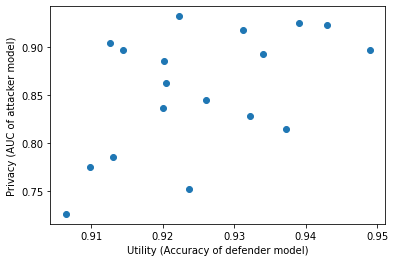

In [22]:
import matplotlib.pyplot as plt
plt.scatter(utility, privacy)
plt.xlabel('Utility (Accuracy of defender model)')
plt.ylabel('Privacy (AUC of attacker model)')
plt.show()

In [26]:
print(recommendation.kwargs)

{'n_hidden_units': 512, 'n_epochs': 36, 'lr': 0.015434893032603836}


In [ ]:
print(total_time_bbo)

1864.5915877819061
